# Learnable loss

## Setup

In [1]:
import numpy as np

%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch

import higher

from ltl.determinism_helper import seed_generators
seed_generators(2)

from ltl.label_smoothing_loss import LabelSmoothingLoss
from ltl import utils

## Data

In [2]:
data_x = 0.0
data_y = -2.0
data_size = 0.3
data_width = 12.0
data_height = 6.0
data_counts = ([200,200,200],[75,75,75],[75,75,75])
data_counts_acc = ([0],[0],[0])
for i in range(len(data_counts)):
    for j in range(len(data_counts[i])):
        data_counts_acc[i].append(data_counts_acc[i][j]+data_counts[i][j])
data_functions = [
    lambda x: torch.cos(x), 
    lambda x: torch.full_like(x, 3.0)
]

def generateData(counts, noise=True):
    #Generate random points
    points = torch.rand((counts[0], 2), dtype=torch.float32)
    points[:,0] = data_x+points[:,0]*data_width
    points[:,1] = data_y+points[:,1]*data_height
    labels = torch.zeros((counts[0],), dtype=torch.long)

    #Remove random points from areas around functions
    for func in data_functions:
        points[:,1] += data_size*(torch.abs(points[:,1]-func(points[:,0]))<data_size)*torch.sign(points[:,1]-func(points[:,0]))

    #Generate points at function
    for i in range(len(data_functions)):
        tmp = data_x+torch.rand((counts[i+1],), dtype=torch.float32)*data_width
        points = torch.cat((points, torch.stack((tmp, data_functions[i](tmp)+(2.0*torch.rand((counts[i+1],))-1.0)*2.0/3.0*data_size), dim=1)))
        labels = torch.cat((labels, torch.full((counts[i+1],), i+1, dtype=torch.long)))

    if noise:
        for i in range(labels.shape[0]):
            labels[i] = utils._lgnt(torch.tensor([[0.80,0.1,0.1],[0.15,0.85,0.0],[0.15,0.0,0.85]]), labels[i])

    return points, labels

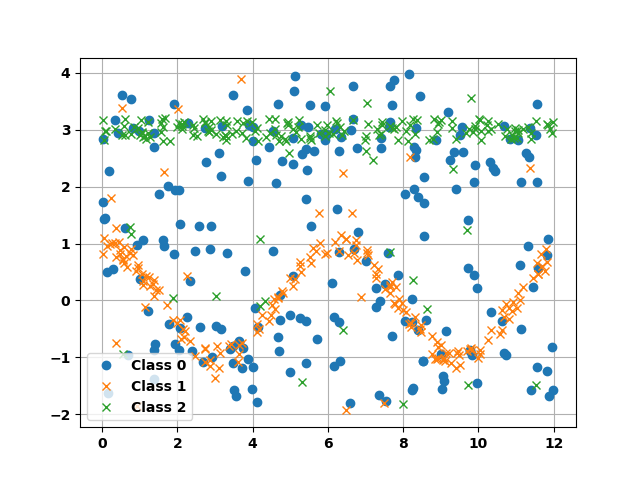

In [3]:
x_train, y_train = generateData(data_counts[0])

fig = plt.figure()
axes = fig.add_subplot(111)
axes.plot(x_train[y_train==0,0], x_train[y_train==0,1], 'o', label='Class 0')
axes.plot(x_train[y_train==1,0], x_train[y_train==1,1], 'x', label='Class 1')
axes.plot(x_train[y_train==2,0], x_train[y_train==2,1], 'x', label='Class 2')
axes.legend()
axes.grid()

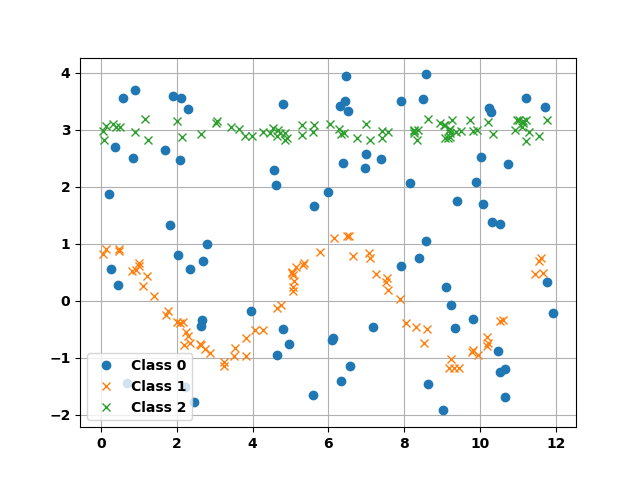

In [4]:
x_val, y_val = generateData(data_counts[1], False)

fig = plt.figure()
axes = fig.add_subplot(111)
axes.plot(x_val[y_val==0,0], x_val[y_val==0,1], 'o', label='Class 0')
axes.plot(x_val[y_val==1,0], x_val[y_val==1,1], 'x', label='Class 1')
axes.plot(x_val[y_val==2,0], x_val[y_val==2,1], 'x', label='Class 2')
axes.legend()
axes.grid()

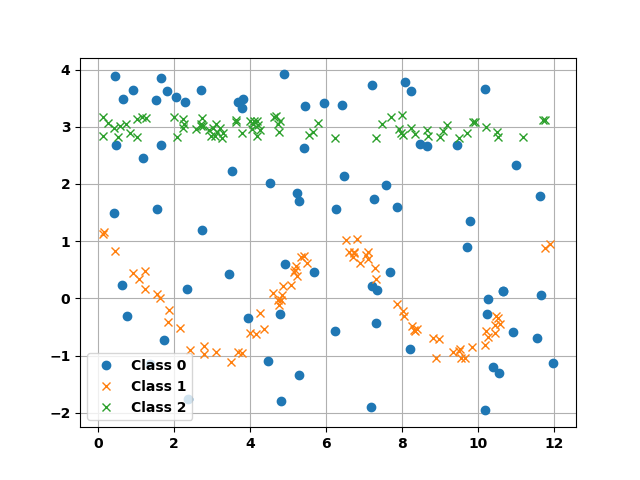

In [5]:
x_test, y_test = generateData(data_counts[2], False)

fig = plt.figure()
axes = fig.add_subplot(111)
axes.plot(x_test[y_test==0,0], x_test[y_test==0,1], 'o', label='Class 0')
axes.plot(x_test[y_test==1,0], x_test[y_test==1,1], 'x', label='Class 1')
axes.plot(x_test[y_test==2,0], x_test[y_test==2,1], 'x', label='Class 2')
axes.legend()
axes.grid()

## Model

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        count_hidden = 45
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, count_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(count_hidden, count_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(count_hidden, count_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(count_hidden, count_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(count_hidden, 3)
        )

    def forward(self, x):
        return self.layers(x)

## Standard

### Training

In [7]:
model = Net()
model.cuda()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

x_train = x_train.cuda()
y_train = y_train.cuda()
x_val   = x_val.cuda()
y_val   = y_val.cuda()
x_test  = x_test.cuda()
y_test  = y_test.cuda()

epochs = 1000
losses_train = np.zeros((epochs,))
accuracy_train = np.zeros((epochs,))
losses_test = np.zeros((epochs,))
accuracy_test = np.zeros((epochs,))

for i in range(epochs):
    z_train = model(x_train)
    loss = loss_function(z_train, y_train)
    losses_train[i] = loss.item()
    accuracy_train[i] = (torch.argmax(torch.nn.functional.softmax(z_train, dim=1), dim=1)==y_train).sum()/data_counts_acc[0][len(data_counts_acc[0])-1]
    losses_test[i] = loss_function(model(x_test), y_test).item()
    accuracy_test[i] = (torch.argmax(torch.nn.functional.softmax(model(x_test), dim=1), dim=1)==y_test).sum()/data_counts_acc[2][len(data_counts_acc[2])-1]
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Evaluation

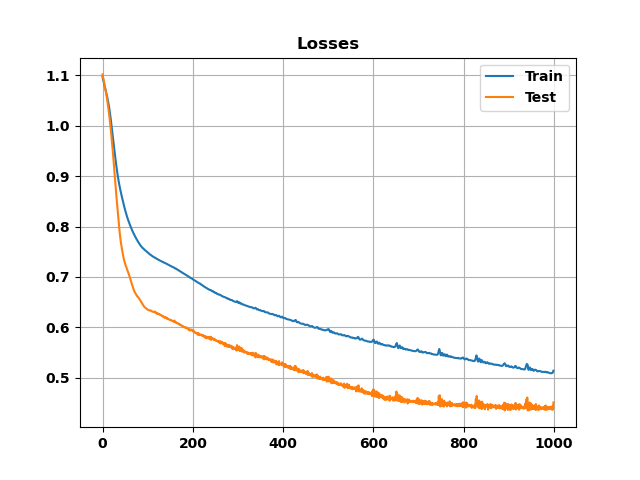

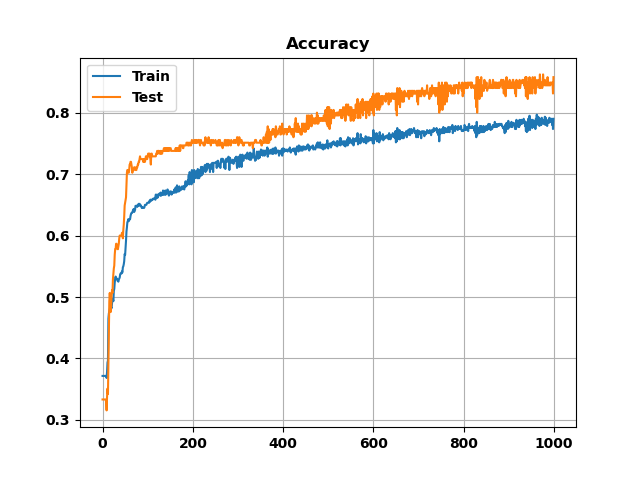

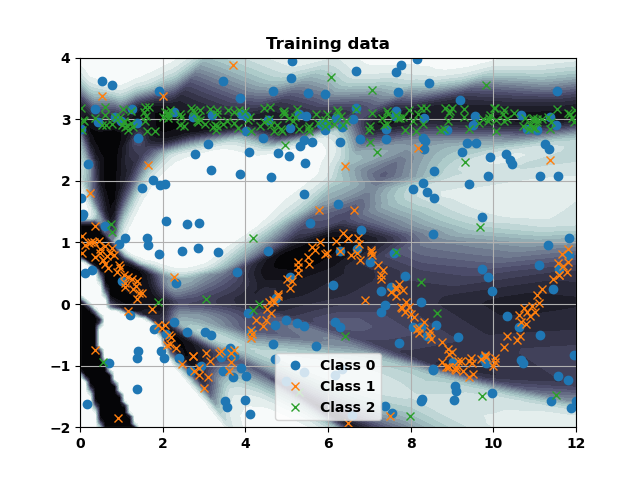

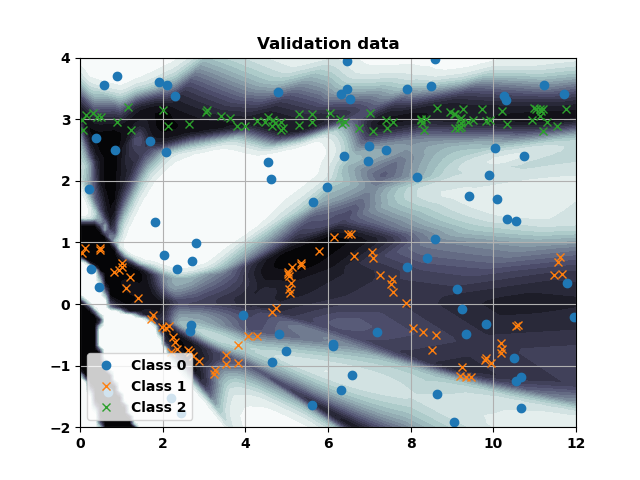

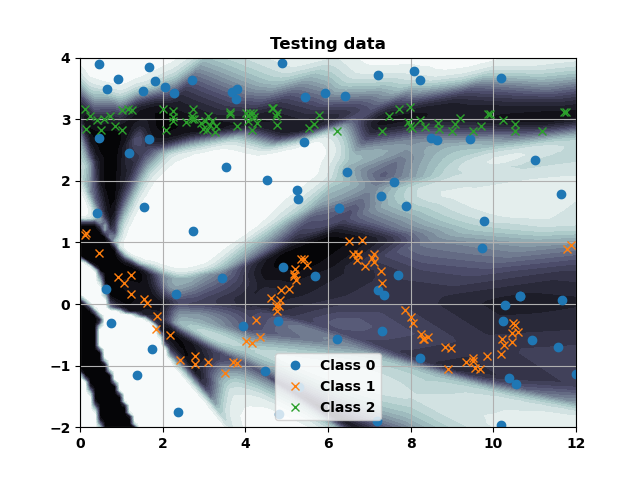

In [8]:
model.eval()
model.cuda()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Losses")
axes.plot(np.arange(losses_train.shape[0]), losses_train, label="Train")
axes.plot(np.arange(losses_test.shape[0]), losses_test, label="Test")
axes.legend()
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Accuracy")
axes.plot(np.arange(accuracy_train.shape[0]), accuracy_train, label="Train")
axes.plot(np.arange(accuracy_test.shape[0]), accuracy_test, label="Test")
axes.legend()
axes.grid()

with torch.no_grad():
    resolution = 100
    grid_x, grid_y = torch.meshgrid(torch.linspace(data_x, data_x+data_width, resolution), torch.linspace(data_y, data_y+data_height, resolution), indexing="ij")
    grid = torch.cat((torch.reshape(grid_x, (-1,1)), torch.reshape(grid_y, (-1,1))), 1)
    
    probs = torch.nn.functional.softmax(model(grid.cuda()), dim=1).cpu()
    output = torch.reshape(probs[:,0], (resolution,resolution))

    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Training data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_train[y_train==0,0].cpu(), x_train[y_train==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_train[y_train==1,0].cpu(), x_train[y_train==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_train[y_train==2,0].cpu(), x_train[y_train==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Validation data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_val[y_val==0,0].cpu(), x_val[y_val==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_val[y_val==1,0].cpu(), x_val[y_val==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_val[y_val==2,0].cpu(), x_val[y_val==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Testing data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_test[y_test==0,0].cpu(), x_test[y_test==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_test[y_test==1,0].cpu(), x_test[y_test==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_test[y_test==2,0].cpu(), x_test[y_test==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()

## Sweep

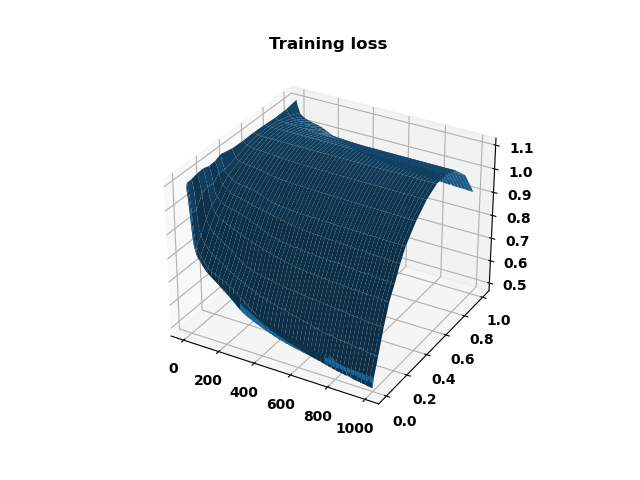

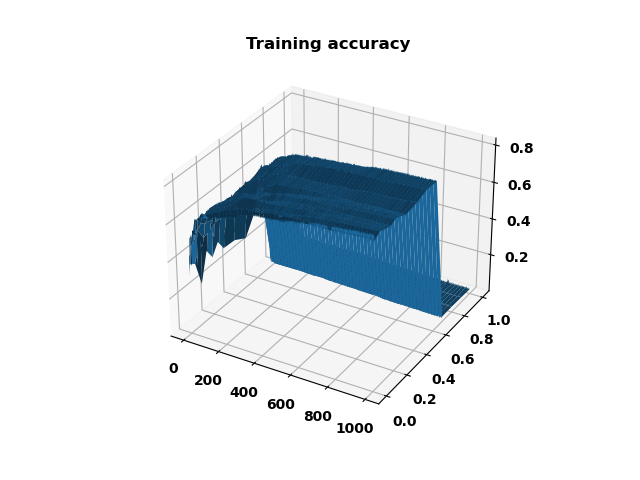

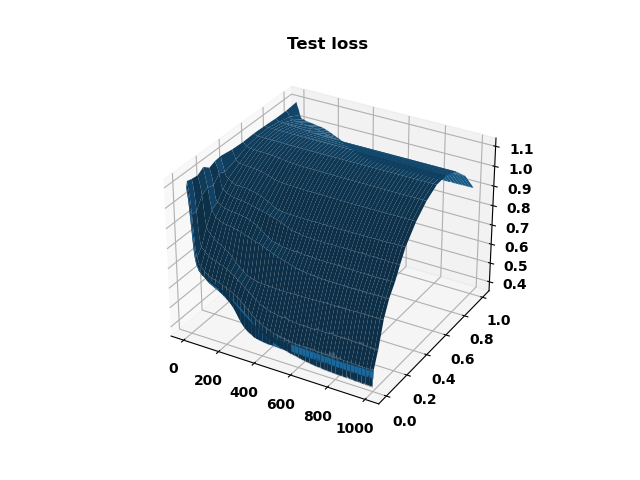

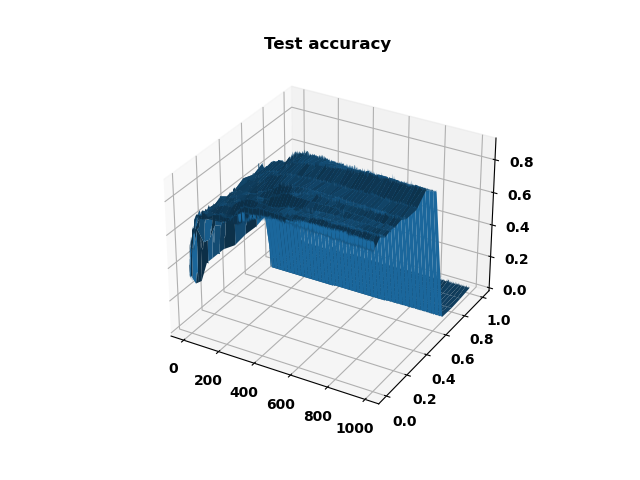

In [9]:
values = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
epochs = 1000
losses_train = np.zeros((len(values),epochs))
accuracy_train = np.zeros((len(values),epochs))
losses_test = np.zeros((len(values),epochs))
accuracy_test = np.zeros((len(values),epochs))
    
for v in range(len(values)):
    model = Net()
    model.cuda()
    loss_function = LabelSmoothingLoss(3, torch.full((1,), values[v]), False)
    loss_function.cuda()
    optimizer = torch.optim.Adam(model.parameters())

    x_train = x_train.cuda()
    y_train = y_train.cuda()
    x_val   = x_val.cuda()
    y_val   = y_val.cuda()
    x_test  = x_test.cuda()
    y_test  = y_test.cuda()

    for i in range(epochs):
        z_train = model(x_train)
        loss = loss_function(z_train, y_train)
        losses_train[v,i] = loss.item()
        accuracy_train[v,i] = (torch.argmax(torch.nn.functional.softmax(z_train, dim=1), dim=1)==y_train).sum()/data_counts_acc[0][len(data_counts_acc[0])-1]
        losses_test[v,i] = loss_function(model(x_test), y_test).item()
        accuracy_test[v,i] = (torch.argmax(torch.nn.functional.softmax(model(x_test), dim=1), dim=1)==y_test).sum()/data_counts_acc[2][len(data_counts_acc[2])-1]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

fig = plt.figure()
axes = fig.add_subplot(111, projection="3d")
axes.set_title("Training loss")
grid_x, grid_y = np.meshgrid(np.arange(epochs)*1.0, np.array(values), indexing="ij")
axes.plot_surface(grid_x, grid_y, losses_train.transpose(1,0))
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111, projection="3d")
axes.set_title("Training accuracy")
grid_x, grid_y = np.meshgrid(np.arange(epochs)*1.0, np.array(values), indexing="ij")
axes.plot_surface(grid_x, grid_y, accuracy_train.transpose(1,0))
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111, projection="3d")
axes.set_title("Test loss")
grid_x, grid_y = np.meshgrid(np.arange(epochs)*1.0, np.array(values), indexing="ij")
axes.plot_surface(grid_x, grid_y, losses_test.transpose(1,0))
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111, projection="3d")
axes.set_title("Test accuracy")
grid_x, grid_y = np.meshgrid(np.arange(epochs)*1.0, np.array(values), indexing="ij")
axes.plot_surface(grid_x, grid_y, accuracy_test.transpose(1,0))
axes.grid()

## Constant

### Training

In [10]:
model = Net()
model.cuda()
loss_function = LabelSmoothingLoss(3, torch.full((1,), 0.1), False)
loss_function.cuda()
optimizer = torch.optim.Adam(model.parameters())

x_train = x_train.cuda()
y_train = y_train.cuda()
x_val   = x_val.cuda()
y_val   = y_val.cuda()
x_test  = x_test.cuda()
y_test  = y_test.cuda()

epochs = 1000
losses_train = np.zeros((epochs,))
accuracy_train = np.zeros((epochs,))
losses_test = np.zeros((epochs,))
accuracy_test = np.zeros((epochs,))

for i in range(epochs):
    z_train = model(x_train)
    loss = loss_function(z_train, y_train)
    losses_train[i] = loss.item()
    accuracy_train[i] = (torch.argmax(torch.nn.functional.softmax(z_train, dim=1), dim=1)==y_train).sum()/data_counts_acc[0][len(data_counts_acc[0])-1]
    losses_test[i] = loss_function(model(x_test), y_test).item()
    accuracy_test[i] = (torch.argmax(torch.nn.functional.softmax(model(x_test), dim=1), dim=1)==y_test).sum()/data_counts_acc[2][len(data_counts_acc[2])-1]
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
                    
    print()

model.eval()
with torch.no_grad():
    z_test = model(x_test)
    print(f"Test loss: {loss_function(z_test, y_test)}")

### Evaluation

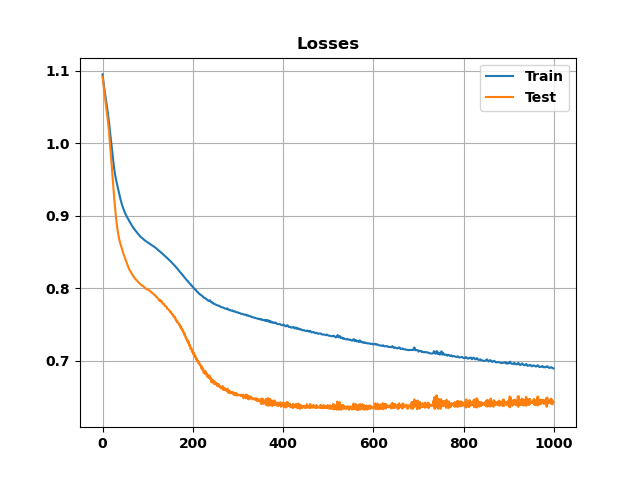

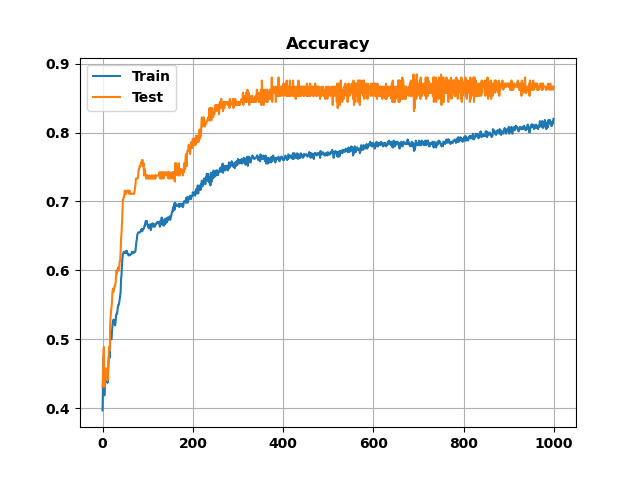

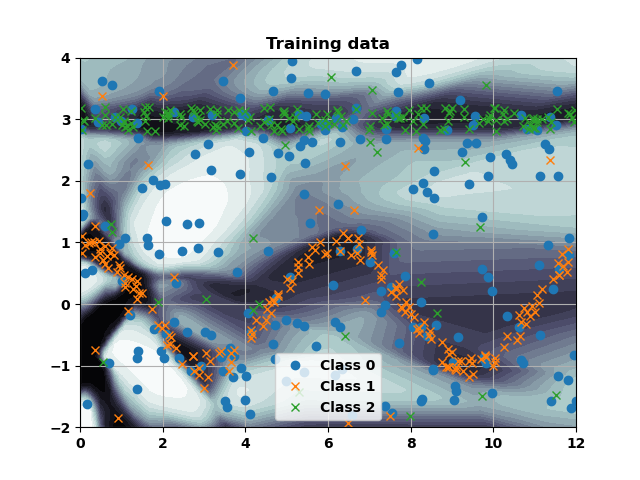

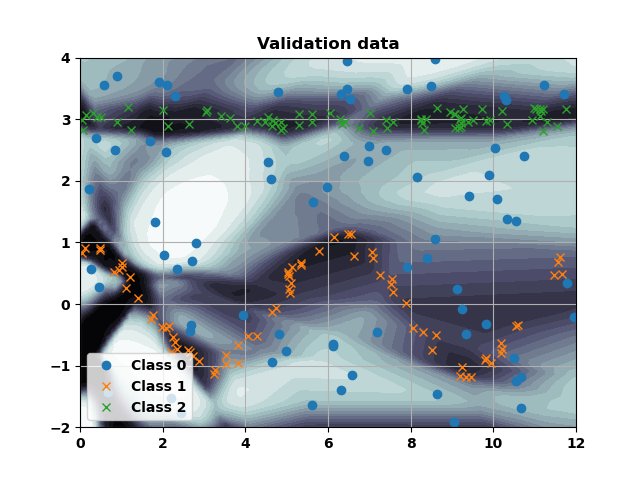

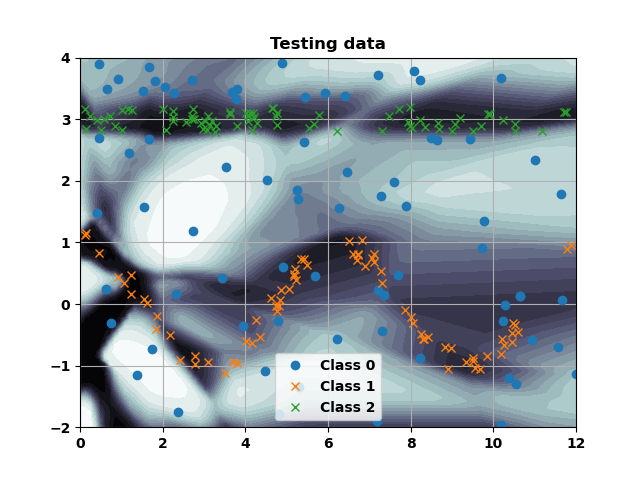

In [11]:
model.eval()
model.cuda()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Losses")
axes.plot(np.arange(losses_train.shape[0]), losses_train, label="Train")
axes.plot(np.arange(losses_test.shape[0]), losses_test, label="Test")
axes.legend()
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Accuracy")
axes.plot(np.arange(accuracy_train.shape[0]), accuracy_train, label="Train")
axes.plot(np.arange(accuracy_test.shape[0]), accuracy_test, label="Test")
axes.legend()
axes.grid()

with torch.no_grad():
    resolution = 100
    grid_x, grid_y = torch.meshgrid(torch.linspace(data_x, data_x+data_width, resolution), torch.linspace(data_y, data_y+data_height, resolution), indexing="ij")
    grid = torch.cat((torch.reshape(grid_x, (-1,1)), torch.reshape(grid_y, (-1,1))), 1)
    
    probs = torch.nn.functional.softmax(model(grid.cuda()), dim=1).cpu()
    output = torch.reshape(probs[:,0], (resolution,resolution))

    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Training data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_train[y_train==0,0].cpu(), x_train[y_train==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_train[y_train==1,0].cpu(), x_train[y_train==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_train[y_train==2,0].cpu(), x_train[y_train==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Validation data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_val[y_val==0,0].cpu(), x_val[y_val==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_val[y_val==1,0].cpu(), x_val[y_val==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_val[y_val==2,0].cpu(), x_val[y_val==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Testing data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_test[y_test==0,0].cpu(), x_test[y_test==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_test[y_test==1,0].cpu(), x_test[y_test==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_test[y_test==2,0].cpu(), x_test[y_test==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()

## Simultan

### Training

In [12]:
model = Net()
model.cuda()
loss_function = LabelSmoothingLoss(3, torch.full((1,), -2.2))
loss_function.cuda()
net_optimizer = torch.optim.Adam(model.parameters())
loss_optimizer = torch.optim.SGD(loss_function.parameters(), lr=1e-1)

x_train = x_train.cuda()
y_train = y_train.cuda()
x_val   = x_val.cuda()
y_val   = y_val.cuda()
x_test  = x_test.cuda()
y_test  = y_test.cuda()

epochs = 1000
losses_train = np.zeros((epochs,))
accuracy_train = np.zeros((epochs,))
losses_test = np.zeros((epochs,))
accuracy_test = np.zeros((epochs,))
smoothings = np.zeros((epochs,))

for i in range(epochs):
    z_train = model(x_train)
    loss = loss_function(z_train, y_train)
    print(f"Loss: {loss.item()}")
    losses_train[i] = loss.item()
    accuracy_train[i] = (torch.argmax(torch.nn.functional.softmax(z_train, dim=1), dim=1)==y_train).sum()/data_counts_acc[0][len(data_counts_acc[0])-1]
    losses_test[i] = loss_function(model(x_test), y_test).item()
    accuracy_test[i] = (torch.argmax(torch.nn.functional.softmax(model(x_test), dim=1), dim=1)==y_test).sum()/data_counts_acc[2][len(data_counts_acc[2])-1]
    smoothings[i] = loss_function.smoothing.item()
    net_optimizer.zero_grad()
    loss_optimizer.zero_grad()
    loss.backward()
    net_optimizer.step()
    loss_optimizer.step()
                    
    print()

model.eval()
with torch.no_grad():
    z_test = model(x_test)
    print(f"Test loss: {loss_function(z_test, y_test)}")

Loss: 1.1111136674880981

Loss: 1.1044234037399292

Loss: 1.0991359949111938

Loss: 1.0948302745819092

Loss: 1.090721607208252

Loss: 1.0865110158920288

Loss: 1.0821164846420288

Loss: 1.0774881839752197

Loss: 1.0725103616714478

Loss: 1.0672520399093628

Loss: 1.061765193939209

Loss: 1.0561867952346802

Loss: 1.050483226776123

Loss: 1.044729471206665

Loss: 1.0389182567596436

Loss: 1.0330171585083008

Loss: 1.0269547700881958

Loss: 1.0205743312835693

Loss: 1.0138323307037354

Loss: 1.0068352222442627

Loss: 0.9995906949043274

Loss: 0.9923079609870911

Loss: 0.9849990010261536

Loss: 0.9777834415435791

Loss: 0.9707739353179932

Loss: 0.9640525579452515

Loss: 0.9577111005783081

Loss: 0.951850175857544

Loss: 0.946657121181488

Loss: 0.9419940710067749

Loss: 0.9378705024719238

Loss: 0.9342928528785706

Loss: 0.9312569499015808

Loss: 0.92864990234375

Loss: 0.9263647794723511

Loss: 0.9243173599243164

Loss: 0.9224591255187988

Loss: 0.9206912517547607

Loss: 0.918776988983

### Evaluation

C:\Users\alexa\AppData\Local\Temp/ipykernel_23196/248309543.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


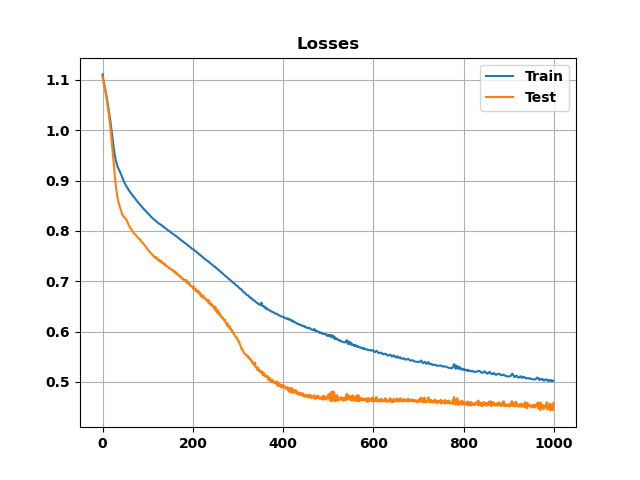

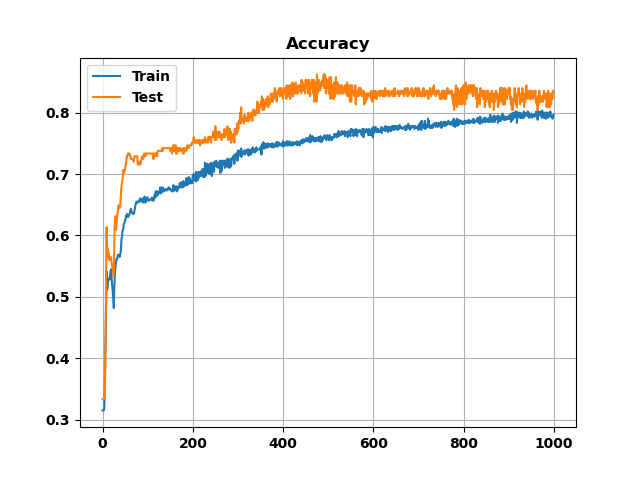

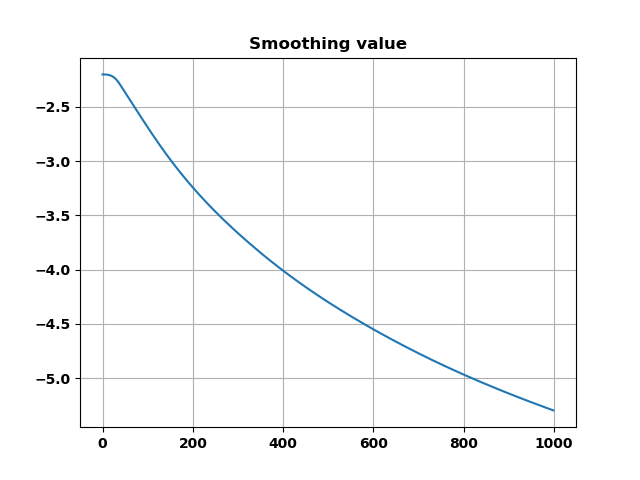

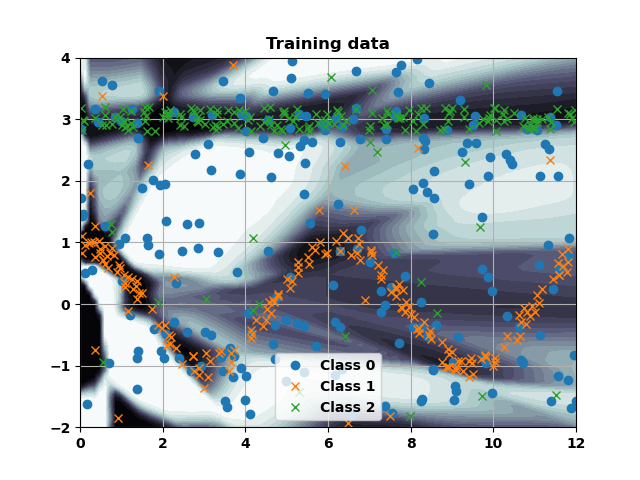

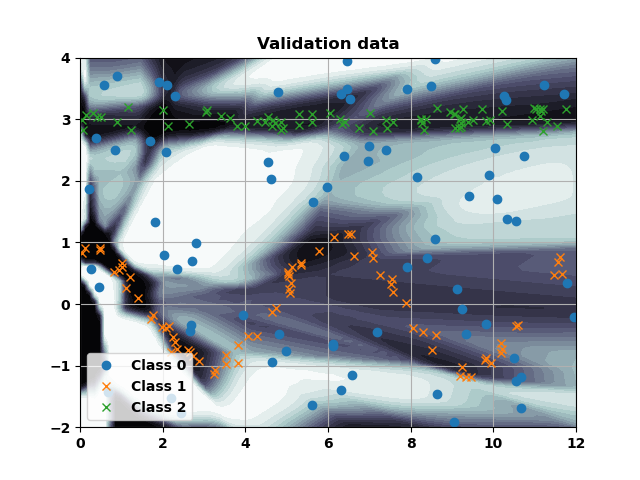

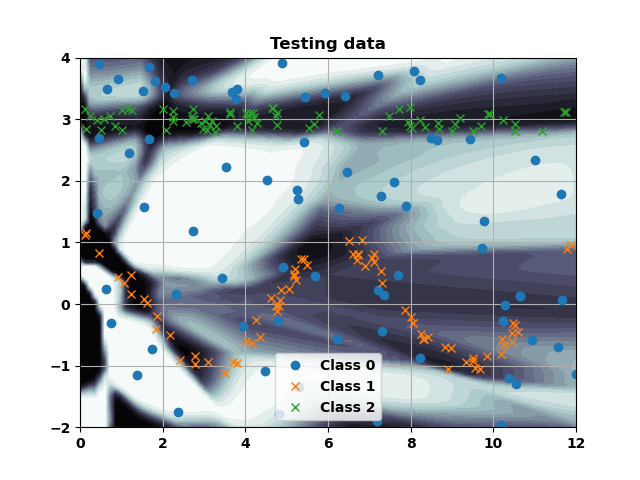

In [13]:
model.eval()
model.cuda()


fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Losses")
axes.plot(np.arange(losses_train.shape[0]), losses_train, label="Train")
axes.plot(np.arange(losses_test.shape[0]), losses_test, label="Test")
axes.legend()
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Accuracy")
axes.plot(np.arange(accuracy_train.shape[0]), accuracy_train, label="Train")
axes.plot(np.arange(accuracy_test.shape[0]), accuracy_test, label="Test")
axes.legend()
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Smoothing value")
axes.plot(np.arange(smoothings.shape[0]), smoothings)
axes.grid()

with torch.no_grad():
    resolution = 100
    grid_x, grid_y = torch.meshgrid(torch.linspace(data_x, data_x+data_width, resolution), torch.linspace(data_y, data_y+data_height, resolution), indexing="ij")
    grid = torch.cat((torch.reshape(grid_x, (-1,1)), torch.reshape(grid_y, (-1,1))), 1)
    
    probs = torch.nn.functional.softmax(model(grid.cuda()), dim=1).cpu()
    output = torch.reshape(probs[:,0], (resolution,resolution))

    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Training data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_train[y_train==0,0].cpu(), x_train[y_train==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_train[y_train==1,0].cpu(), x_train[y_train==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_train[y_train==2,0].cpu(), x_train[y_train==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Validation data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_val[y_val==0,0].cpu(), x_val[y_val==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_val[y_val==1,0].cpu(), x_val[y_val==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_val[y_val==2,0].cpu(), x_val[y_val==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Testing data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_test[y_test==0,0].cpu(), x_test[y_test==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_test[y_test==1,0].cpu(), x_test[y_test==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_test[y_test==2,0].cpu(), x_test[y_test==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()

## Bilevel

### Training

In [14]:
model = Net()
model.cuda()
inner_loss_function = LabelSmoothingLoss(3, torch.full((1,),-2.2))#torch.diag(torch.ones((3,))))
inner_loss_function.cuda()
outer_loss_function = torch.nn.CrossEntropyLoss()
inner_optimizer = torch.optim.Adam(model.parameters())
outer_optimizer = torch.optim.SGD(inner_loss_function.parameters(), lr=1e-1)

x_train = x_train.cuda()
y_train = y_train.cuda()
x_val   = x_val.cuda()
y_val   = y_val.cuda()
x_test  = x_test.cuda()
y_test  = y_test.cuda()

#############
inner_optimizer.zero_grad()
inner_loss_function(model(x_train[0].unsqueeze(0)), y_train[0].unsqueeze(0)).backward()
inner_optimizer.step()
#############

epochs = 1000
inner_iterations = 5
inner_losses_train   = np.zeros((epochs,))
outer_losses_val   = np.zeros((epochs,))
losses_test   = np.zeros((epochs,))
inner_accuracy_train = np.zeros((epochs,))
outer_accuracy_val = np.zeros((epochs,))
accuracy_test = np.zeros((epochs,))
smoothings     = np.zeros((epochs,))

for i in range(epochs):
    with higher.innerloop_ctx(model, inner_optimizer) as (fmodel, diffopt):
        loss_acc = 0
        acc_acc = 0
        for j in range(inner_iterations):
            z_train = fmodel(x_train)
            inner_loss = inner_loss_function(z_train, y_train)
            loss_acc += inner_loss.item()
            acc_acc += (torch.argmax(torch.nn.functional.softmax(z_train.detach(), dim=1), dim=1)==y_train).sum()/data_counts_acc[0][len(data_counts_acc[0])-1]
            diffopt.step(inner_loss)
        new_model_state = fmodel.state_dict()
        new_optimizer_state = diffopt.state[0]
        inner_losses_train[i] = loss_acc/inner_iterations
        inner_accuracy_train[i] = acc_acc/inner_iterations
            
        z_val = fmodel(x_val)
        outer_loss = outer_loss_function(z_val, y_val)
        outer_accuracy_val[i] = (torch.argmax(torch.nn.functional.softmax(z_val, dim=1), dim=1)==y_val).sum()/data_counts_acc[1][len(data_counts_acc[1])-1]
        outer_losses_val[i] = outer_loss.item()
        outer_optimizer.zero_grad()
        outer_loss.backward()
        outer_optimizer.step()
        smoothings[i] = inner_loss_function.smoothing.item()

    losses_test[i] = loss_function(model(x_test), y_test).item()
    accuracy_test[i] = (torch.argmax(torch.nn.functional.softmax(model(x_test), dim=1), dim=1)==y_test).sum()/data_counts_acc[2][len(data_counts_acc[2])-1]

    utils.copy_higher_to_torch(new_model_state, new_optimizer_state, model, inner_optimizer)

### Evaluation

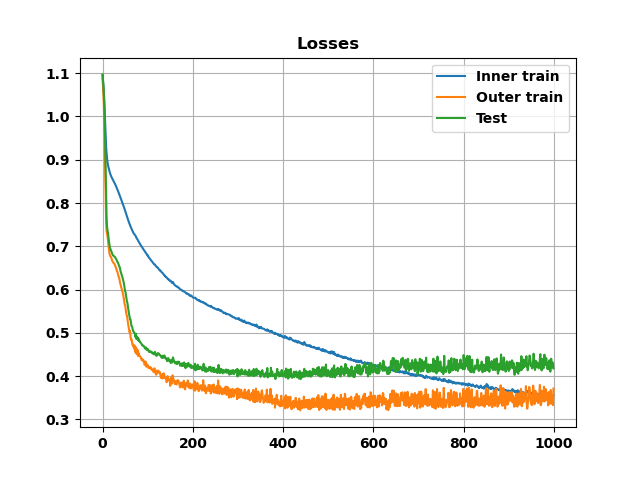

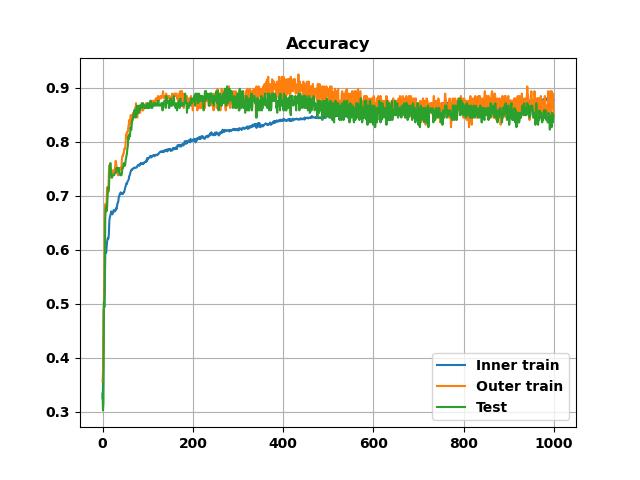

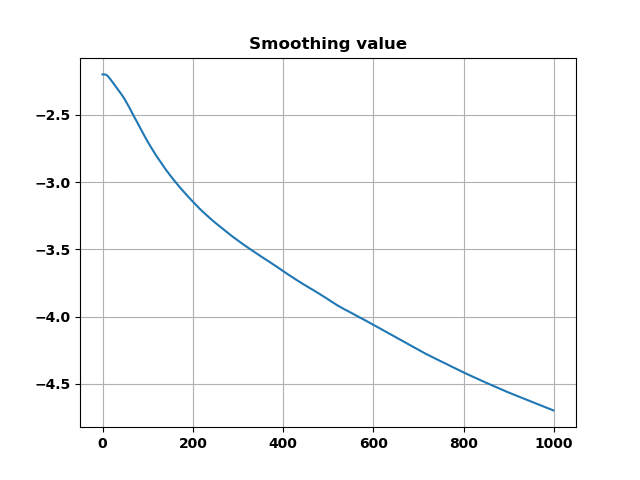

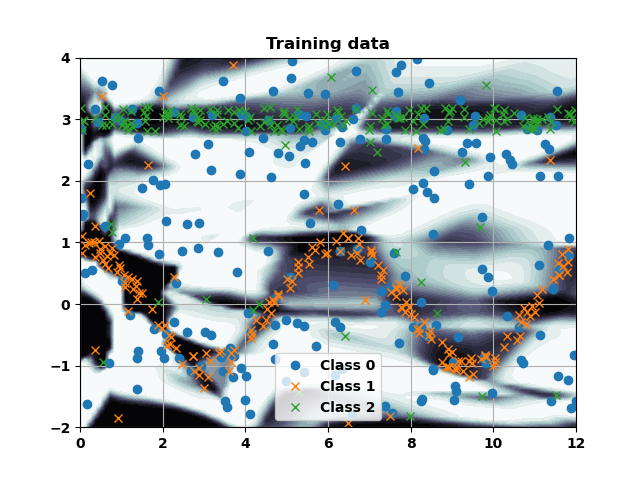

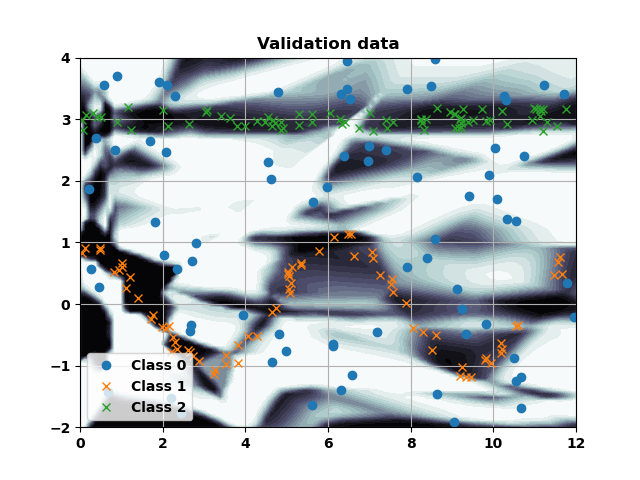

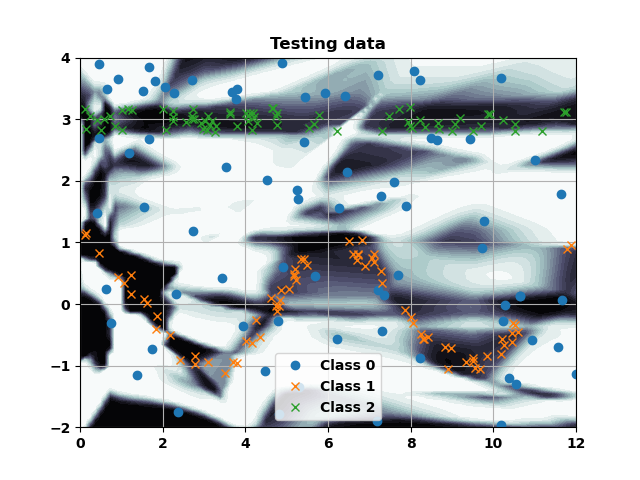

In [15]:
model.eval()
model.cuda()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Losses")
axes.plot(np.arange(inner_losses_train.shape[0]), inner_losses_train, label="Inner train")
axes.plot(np.arange(outer_losses_val.shape[0]), outer_losses_val, label="Outer train")
axes.plot(np.arange(losses_test.shape[0]), losses_test, label="Test")
axes.legend()
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Accuracy")
axes.plot(np.arange(inner_accuracy_train.shape[0]), inner_accuracy_train, label="Inner train")
axes.plot(np.arange(outer_accuracy_val.shape[0]), outer_accuracy_val, label="Outer train")
axes.plot(np.arange(accuracy_test.shape[0]), accuracy_test, label="Test")
axes.legend()
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Smoothing value")
axes.plot(np.arange(smoothings.shape[0]), smoothings)
axes.grid()

with torch.no_grad():
    resolution = 100
    grid_x, grid_y = torch.meshgrid(torch.linspace(data_x, data_x+data_width, resolution), torch.linspace(data_y, data_y+data_height, resolution), indexing="ij")
    grid = torch.cat((torch.reshape(grid_x, (-1,1)), torch.reshape(grid_y, (-1,1))), 1)
    
    probs = torch.nn.functional.softmax(model(grid.cuda()), dim=1).cpu()
    output = torch.reshape(probs[:,0], (resolution,resolution))

    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Training data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_train[y_train==0,0].cpu(), x_train[y_train==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_train[y_train==1,0].cpu(), x_train[y_train==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_train[y_train==2,0].cpu(), x_train[y_train==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Validation data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_val[y_val==0,0].cpu(), x_val[y_val==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_val[y_val==1,0].cpu(), x_val[y_val==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_val[y_val==2,0].cpu(), x_val[y_val==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Testing data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_test[y_test==0,0].cpu(), x_test[y_test==0,1].cpu(), 'o', label='Class 0')
    axes.plot(x_test[y_test==1,0].cpu(), x_test[y_test==1,1].cpu(), 'x', label='Class 1')
    axes.plot(x_test[y_test==2,0].cpu(), x_test[y_test==2,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()

    #utils.render_matrix(inner_loss_function.smoothing.clone().detach().cpu().numpy(), "Smoothing matrix", "Weight", "Correct label")